## Outline

1. Introduce dataset 
2. Data processing - Test-train split, encoding, visualisation
3. Basic RNN - testing inference
4. Evaluation and training
5. LSTM
6. GRU
7. Exercises

### Setting up the dependencies

In [0]:
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0) # For deterministic flow of random numbers for reproducibility

In [0]:
from IPython.display import clear_output

## Dataset

### Pre-processing

In [0]:
!wget -nc -q --show-progress https://raw.githubusercontent.com/GokulNC/NLP-Exercises/master/Name2Nationality/name2lang.txt
languages = []
data = []
X = []
y = []

with open('name2lang.txt', 'r') as f: 
    for line in f:
        line = line.split(',')
        name = line[0].strip()
        lang = line[1].strip()
        if not lang in languages:
            languages.append(lang)
        X.append(name)
        y.append(lang)
        data.append((name, lang))

n_languages = len(languages)

In [0]:
print(languages)

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


In [0]:
print(data[0:10])

[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]


### Test-train split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [0]:
print(X_train)

['Abashkin', 'Gulimov', 'Tzelobenok', 'Funnell', 'Zhui', 'Jukes', 'Togunov', 'Sabbag', 'Kartomyshev', 'Makhnenko', 'Sokolsky', 'Masuno', 'Varela', 'Moffat', 'Bonner', 'Berezovsky', 'Helkvist', 'Thurston', 'Tovstuha', 'Millar', 'Tulintsev', 'Furey', 'Isaenko', 'Kalachev', 'Takecare', 'Newcombe', 'Taku', 'Artibyakin', 'Saifulov', 'Morcos', 'Jagodnikov', 'Halifman', 'Bagaryakoff', 'Pavluhin', 'Mari', 'Awramchik', 'Agaltsov', 'Fisichev', 'Shizuma', 'Yankin', 'Luts', 'Toshitala', 'Germain', 'Botros', 'Poulter', 'Lischenko', 'Porter', 'Melendez', 'Ibu', 'Carr', 'Ursler', 'Aderikhin', 'Gimondi', 'Rzhevsky', 'Slater', 'Atkin', 'Yagafarov', 'Huraskin', 'Underhill', 'Pylin', 'Yuschenko', 'Ardovini', 'Tunison', 'Dobrovolsky', 'Bezyzvestnyh', 'Roussel', 'Balakshin', 'Trumbauer', 'Vallance', 'Boerio', 'Waugh', 'Baz', 'Reading', 'Komon', 'Ireson', 'Venables', 'Tikhotsky', 'Spada', 'Winfield', 'Mikhnov', 'Lubsky', 'Antar', 'Sheehan', 'Tuma', 'Yuzefovich', 'Yamburg', 'Yukhvidov', 'Mikhail', 'Chi', 'De

In [0]:
print(len(X_train), len(X_test))

16040 4010


### Encoding names and language

In [0]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [0]:
def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [0]:
def lang_rep(lang):
    return torch.tensor([languages.index(lang)], dtype=torch.long)

In [0]:
name_rep('Abreu')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [0]:
lang_rep('Portuguese')

tensor([0])

### Basic visualisation

In [0]:
count = {}
for l in languages: 
    count[l] = 0
for d in data:
    count[d[1]] += 1

In [0]:
print(count)

{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


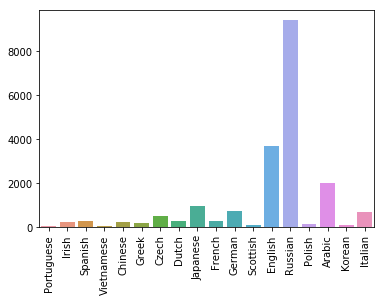

In [0]:
plt_ = sns.barplot(list(count.keys()), list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(), rotation=90)
plt.show()

## Basic network and testing inference

In [0]:
class RNN_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None, batch_size = 1):
        out, hidden = self.rnn_cell(input, hidden)
        output = self.h2o(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def get_hidden(self, batch_size = 1):
        return torch.zeros(1, batch_size, self.hidden_size)

In [0]:
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages)

In [0]:
def infer(net, name, device = 'cpu'):
    name_ohe = name_rep(name).to(device)
    
    output, hidden = net(name_ohe)
        
    if type(hidden) is tuple: # For LSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)
    
    return output

In [0]:
infer(net, 'Adam')

tensor([[-2.9016, -2.9064, -2.9751, -2.8264, -2.8491, -2.9686, -2.8243, -2.9429,
         -2.8852, -2.9349, -2.7825, -2.9892, -2.9006, -2.8989, -2.9241, -2.7985,
         -2.9926, -2.7686]], grad_fn=<LogSoftmaxBackward>)

## Evaluate model

In [0]:
def dataloader(npoints, X_, y_):
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
    return to_ret

# Returns OHE's of the given batch
def name_rep_batched(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

def lang_rep_batched(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = languages.index(lang)
    return rep

def dataloader_padded(npoints, X_, y_, device = 'cpu'):
    names = []
    langs = []
    X_lengths = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        X_lengths.append(len(name))
        names.append(name)
        langs.append(lang)
    longest_word = max(X_lengths)
    names_rep_tensor = name_rep_batched(names, longest_word).to(device)
    langs_rep_tensor = lang_rep_batched(langs).to(device)
    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep_tensor, X_lengths, enforce_sorted = False)
    
    return padded_names_rep.to(device), langs_rep_tensor

In [0]:
def eval(net, n_points, topk, X_, y_, device = 'cpu'):
    net = net.eval().to(device)
    data_ = dataloader(n_points, X_, y_)
    correct = 0
    
    for name, language, name_ohe, lang_rep in data_:
        
        output = infer(net, name, device)
        val, indices = output.topk(topk)
        indices = indices.to('cpu')
        
        if lang_rep in indices:
            correct += 1
            
    accuracy = correct/n_points
    return accuracy

In [0]:
eval(net, 1000, 1, X_test, y_test)

0.046

## Training

### Basic setup

In [0]:
def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    total_loss = 0
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i:i+1], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
    return total_loss/n_points

def train_batch(net, opt, criterion, n_points, device = 'cpu'):
    net.train().to(device)
    opt.zero_grad()
    batch_input, batch_groundtruth = dataloader_padded(n_points, X_train, y_train, device)
    output, hidden = net(batch_input)
    loss = criterion(output, batch_groundtruth)
    loss.backward()
    opt.step()
    return loss

In [0]:
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [0]:
%%time 
train(net, opt, criterion, 200)

CPU times: user 378 ms, sys: 21.5 ms, total: 400 ms
Wall time: 418 ms


tensor(2.8984, grad_fn=<DivBackward0>)

In [0]:
eval(net, 1000, 1, X_test, y_test)

0.477

### Full training setup

In [0]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    net = net.to(device)
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            # print('Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test))
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
    print('Top-1:', eval(net, len(X_test), 1, X_test, y_test, device), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test, device))
                      

## RNN Cell

Iteration 9999 Loss 0.22312211990356445


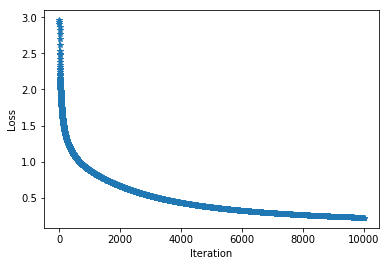




Top-1: 0.7783042394014963 Top-2: 0.8718204488778055
CPU times: user 9min 52s, sys: 41 s, total: 10min 33s
Wall time: 10min 14s


In [0]:
%%time
net = RNN_net(n_letters, 128, n_languages)
train_setup(net, lr=0.05, n_batches=10000, batch_size = 512, display_freq=100) # CPU Training example

Iteration 9999 Loss 0.22198523581027985


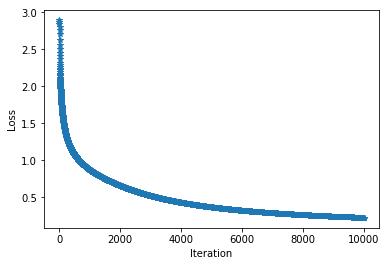




Top-1: 0.7685785536159601 Top-2: 0.8725685785536159
CPU times: user 7min 31s, sys: 40.8 s, total: 8min 12s
Wall time: 7min 52s


In [0]:
%%time
net = RNN_net(n_letters, 128, n_languages)
train_setup(net, lr=0.05, n_batches=10000, batch_size = 512, display_freq=100, device = device_gpu) # GPU Training Example

## LSTM cell

In [0]:
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None):
        out, hidden = self.lstm_cell(input, hidden)
        output = self.h2o(hidden[0].view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def get_hidden(self, batch_size = 1):
        return (torch.zeros(1, batch_size, self.hidden_size), torch.zeros(1, batch_size, self.hidden_size))

Iteration 99999 Loss 0.17066246271133423


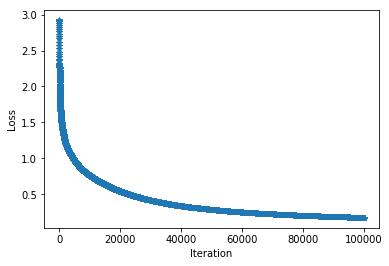




Top-1: 0.8102244389027431 Top-2: 0.9024937655860349


In [0]:
n_hidden = 128
net = LSTM_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.05, n_batches=100000, batch_size = 16, display_freq=100, device = device_gpu)

## GRU Cell

In [0]:
class GRU_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_net, self).__init__()
        self.hidden_size = hidden_size
        self.gru_cell = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None):
        out, hidden = self.gru_cell(input, hidden)
        output = self.h2o(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden

Iteration 999 Loss 1.2766666412353516


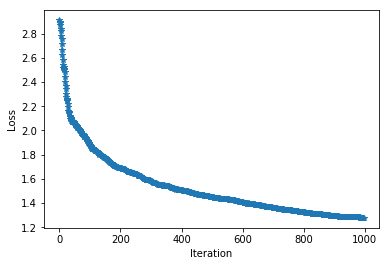




Top-1: 0.7017456359102244 Top-2: 0.8037406483790523


In [0]:
n_hidden = 128
net = GRU_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.05, n_batches=1000, batch_size = 16, display_freq=100, device = device_gpu)

## Exercises

0. Compute language-wise accuracy, plot confusion matrix 
1. Play with hyper-parameters (includes hidden layer size) and try to get better results
2. Observe gradient explosion at higher learning rates
3. Increase performance by moving to GPUs (shown earlier)
4. Think about how to increase performance further (idea: are we benefiting from batching in our implementation?)
